# Import libraries

In [1]:
#using KernelEstimator
using Distributions
using LinearAlgebra
using KernelDensity
using MultiKDE
using Plots
using Optim
using DataFrames
using Statistics
using BlockArrays
using Shuffle
using Random
using Pkg
#Pkg.add("ScikitLearn")
using ScikitLearn
@sk_import covariance : LedoitWolf

PyObject <class 'sklearn.covariance._shrunk_covariance.LedoitWolf'>

# Include jl file

In [4]:
include("Denoising.jl")

optPort

# TESTING THE MARCENKO–PASTUR THEOREM

In [5]:
# Random Matrix
X = rand(Normal(0, 1), 10000, 1000)
# Get the eigenvalues and vectors of the correlation matrix of X
eVal0, eVec0 = PCA(cor(X))
# Marcenko-Pastur pdf
pdf0 = pdfMarcenkoPastur(1., size(X)[1]/size(X)[2], 1000)
# Fits a Kernel Density Estimate to the eigenvalues of the correlation matrix
pdf1 = KDE(diag(eVal0), bandWidth = 0.01, kernel = Distributions.Normal, valuesForEvaluating = nothing);

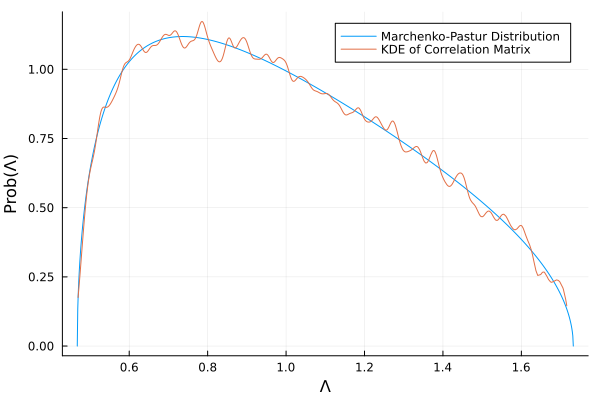

In [6]:
plot(pdf0.index,pdf0.values,label="Marchenko-Pastur Distribution")
plot!(pdf1.index,pdf1.values,label="KDE of Correlation Matrix")
xlabel!("Λ")
ylabel!("Prob(Λ)")

In [7]:
savefig("1.png")

# ADD SIGNAL TO A RANDOM COVARIANCE MATRIX

In [8]:
alpha, numberColumns, numberFactors, ratio = .995, 1000, 100, 10
covv = cov(rand(Normal(0,1),numberColumns*ratio,numberColumns))
covv = alpha*covv + (1 - alpha)*randomCov(numberColumns, numberFactors) # noise+signal
corr0 = covToCorr(covv)
eval0, evec0 = PCA(corr0);

# FITTING THE MARCENKO–PASTUR PDF

In [9]:
emax0, var0 = findMaxEval(diag(eval0), ratio, .01)
numberFactors0 = size(eval0)[1] - searchsortedfirst(reverse(diag(eval0)), emax0) + 1

100

# Denoising

## Constant Residual Eigenvalue Method

In [10]:
corr1 = denoisedCorr(eval0, evec0, numberFactors0)
eval1 , evec1 = PCA(corr1);

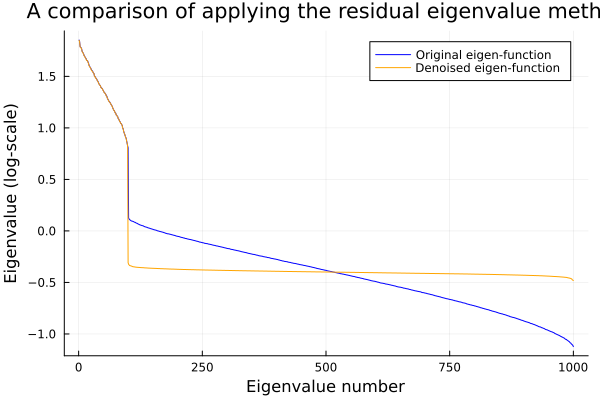

In [11]:
plot(log.(diag(eval0)), c = :blue, title = "A comparison of applying the residual eigenvalue method",
     label = "Original eigen-function")
plot!(log.(diag(eval1)), c = :orange, label = "Denoised eigen-function")
xlabel!("Eigenvalue number")
ylabel!("Eigenvalue (log-scale)")

In [12]:
savefig("3.png")

# Detoning

# DENOISING BY TARGETED SHRINKAG

In [13]:
corr1 = denoisedCorrShrinkage(eval0, evec0, numberFactors0, α = .5)
eval1 , evec1 = PCA(corr1);

# GENERATING A BLOCK-DIAGONAL COVARIANCE MATRIX AND A VECTOR OF MEANS

In [ ]:
nblocks, bsize, bcorr = 10, 50, .5
mu0, cov0 = formTrueMatrix(nblocks, bsize, bcorr);

# DENOISING OF THE EMPIRICAL COVARIANCE MATRIX

 # Minimum Variance Portfolio

In [ ]:
nObs, ntrials, bWidth, shrink, minVarPortf = 100, 100, .01 , false, true
w1 = DataFrames.DataFrame(zeros(ntrials, size(cov0)[1]), :auto)
DataFrames.rename!(w1, names(w1).=>Symbol.(range(1,stop = 500)))
w1_d = copy(w1)
Random.seed!(0)
for i in 1:ntrials
    mu1, cov1 = simCovMu(vcat(mu0...), cov0, nObs, shrink)
    if minVarPortf 
        mu1 = nothing
    end
    cov1_d = deNoiseCov(cov1, nObs/size(cov1)[1], bWidth)
    w1[i, :] = optPort(cov1, mu1)
    w1_d[i, :] = optPort(cov1_d, mu1)
end
first(w1, 10)

# ROOT-MEAN-SQUARE ERRORS

In [ ]:
if minVarPortf
    inp = nothing 
else 
    inp = mu0
end
w0 = optPort(cov0, inp)
w0 = repeat(transpose(w0), size(w1)[1])
rmsd = mean((Matrix(w1) .- w0).^2)^.5 # RMSE
rmsd_d = mean((Matrix(w1_d) .- w0).^2)^.5 # RMSE
println(rmsd)
println(rmsd_d)

# Maximum Sharpe Ratio Portfolio

In [ ]:
nObs, ntrials, bWidth, shrink, minVarPortf = 100, 100, .01 , false, false
w1 = DataFrames.DataFrame(zeros(ntrials, size(cov0)[1]), :auto)
DataFrames.rename!(w1, names(w1).=>Symbol.(range(1,stop = 500)))
w1_d = copy(w1)
Random.seed!(0)
for i in 1:ntrials
    mu1, cov1 = simCovMu(vcat(mu0...), cov0, nObs, shrink)
    if minVarPortf 
        mu1 = nothing
    end
    cov1_d = deNoiseCov(cov1, nObs/size(cov1)[1], bWidth)
    w1[i, :] = optPort(cov1, mu1)
    w1_d[i, :] = optPort(cov1_d, mu1)
end
first(w1, 10)

# ROOT-MEAN-SQUARE ERRORS

In [ ]:
if minVarPortf
    inp = nothing 
else 
    inp = vcat(mu0...)
end
w0 = optPort(cov0, inp)
w0 = repeat(transpose(w0), size(w1)[1])
rmsd = mean((Matrix(w1) .- w0).^2)^.5 # RMSE
rmsd_d = mean((Matrix(w1_d) .- w0).^2)^.5 # RMSE
println(rmsd)
println(rmsd_d)